### Imports

In [ ]:
import finnhub
from datetime import datetime
from datetime import timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Using EMA

### Access stock

In [ ]:
# Setup client
finnhub_client = finnhub.Client(api_key = "bt3efpf48v6tfcs816eg")

# Stock candles
ticker = 'SPY'
start_time = int(datetime(2019, 6, 15, 0, 0).replace(tzinfo = timezone.utc).timestamp())
end_time = int(datetime(2021, 6, 15, 0, 0).replace(tzinfo = timezone.utc).timestamp())
res = finnhub_client.stock_candles(ticker, 'D', start_time, end_time)
# print(res)

stock = pd.DataFrame(res)
stock = stock.rename(columns = {'t':'Date', 'o':'Open', 'h':'High', 'l':'Low', 'c':'Close', 's':'status', 'v':'volumn'})
stock['Date'] = pd.to_datetime(stock['Date'], unit = 's')
stock = stock.set_index('Date')

# display(stock.head())

### EMA

In [3]:
ema_s = 13
ema_l = 21
stock["EMA_S"] = stock.Close.ewm(span = ema_s, min_periods = ema_s).mean()
stock["EMA_L"] = stock.Close.ewm(span = ema_l, min_periods = ema_l).mean()

# display(stock.head(30))

In [4]:
stock = stock.dropna(axis = 0)

### Position

In [5]:
stock['pos_cur'] = 0 # current position
for i in stock.index:
    if ((stock.loc[i, 'EMA_S'] > stock.loc[i, 'EMA_L']) & (stock.loc[i, 'pos_cur'] == 0)):
        stock.loc[i, 'pos_cur'] = 1

### Entry and Exit

In [6]:
stock['EE'] = 0 # entry and exit
ts = 0 # trading signal
for i in stock.index:
    if ((stock.loc[i, 'EMA_S'] >= stock.loc[i, 'EMA_L']) & (ts == 0)):
        ts = 1
        stock.loc[i, 'EE'] = 1
    if ((stock.loc[i, 'EMA_S'] < stock.loc[i, 'EMA_L']) & (ts == 1)):
        ts = 0
        stock.loc[i, 'EE'] = -1

In [7]:
Entry = stock.loc[stock.EE == 1]
Exit = stock.loc[stock.EE == -1]

### On plot

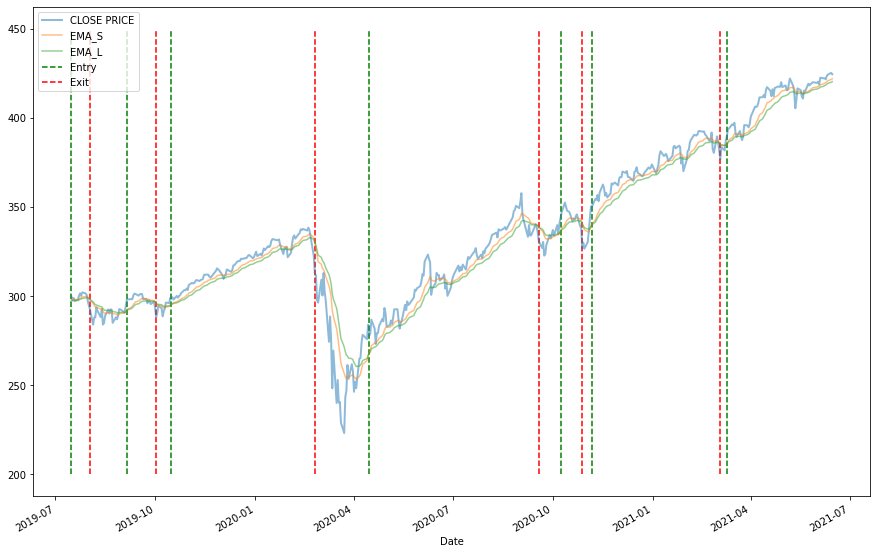

In [8]:
plt.rcParams['figure.figsize'] = [15, 10]
# plt.rc('font', size = 14)
fig, ax = plt.subplots()

stock['Close'].plot(label = 'CLOSE PRICE', linewidth = 2, alpha = 0.5, ax = ax)
stock['EMA_S'].plot(label = 'EMA_S', alpha = 0.5, ax = ax)
stock['EMA_L'].plot(label = 'EMA_L', alpha = 0.5, ax = ax)
ax.vlines(Entry.reset_index().Date, ymin = 200, ymax = 450, color = 'green', linestyle = '--', label = 'Entry')
ax.vlines(Exit.reset_index().Date, ymin = 200, ymax = 450, color = 'red', linestyle = '--', label = 'Exit')

plt.legend(loc = 'upper left')
plt.show()

### Returns

In [9]:
# daily log return
stock.loc[:,'rtn'] = np.log(stock.Close.div(stock.Close.shift(1))) # without strategy
stock.loc[:,'s_rtn'] = stock.pos_cur.shift(1) * stock.rtn # with strategy

stock = stock.dropna(axis = 0)

# cumulative return
stock['crtn'] = stock['rtn'].cumsum().apply(np.exp) # without strategy
stock['s_crtn'] = stock['s_rtn'].cumsum().apply(np.exp) # with strategy

# stock.head(60)

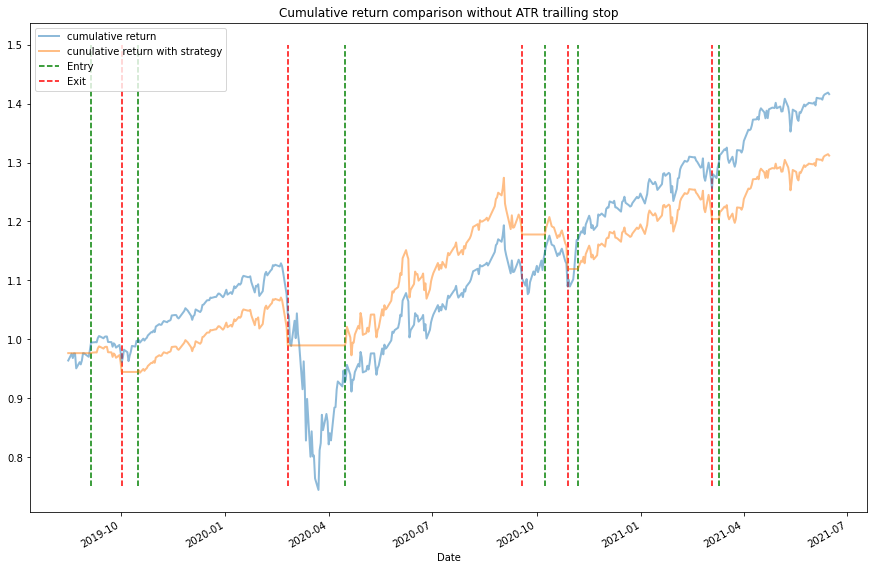

In [54]:
fig, ax = plt.subplots()

stock['crtn'].plot(label = 'cumulative return', linewidth = 2, alpha = 0.5, ax = ax)
stock['s_crtn'].plot(label = 'cunulative return with strategy', linewidth = 2, alpha = 0.5, ax = ax)
ax.vlines(Entry.reset_index().Date, ymin = 0.75, ymax = 1.5, color = 'green', linestyle = '--', label = 'Entry')
ax.vlines(Exit.reset_index().Date, ymin = 0.75, ymax = 1.5, color = 'red', linestyle = '--', label = 'Exit')

plt.legend(loc = 'upper left')
plt.title('Cumulative return comparison without ATR trailling stop')
plt.show()

## Using ATR (Long)

In [11]:
def get_ATR(stock, n):
    hl = stock.High - stock.Low
    hc = abs(stock.High - stock.Close.shift(1))
    lc = abs(stock.Low - stock.Close.shift(1))
    
    stock['TR'] = np.maximum(np.maximum(hl, hc), lc)
    
    stock['ATR'] = stock.TR.rolling(n).mean()
    
    return stock

In [12]:
stock = get_ATR(stock, 21)

In [13]:
stock = stock.dropna()

In [14]:
mul = 3 # multiplier

In [15]:
# stock['ATR_stop'] = np.nan

# stock.loc[stock.pos_cur == 1, 'ATR_stop'] = stock.loc[stock.pos_cur == 1,\
#                                                         'Close'] - mul * stock.loc[stock.pos_cur == 1, 'ATR']

In [16]:
stock['ATR_stop'] = (stock.Close - mul * stock.ATR).shift(1) # ATR_stop for current day

In [18]:
stock['pos_atr'] = np.where(((stock.Close > stock.ATR_stop) & (stock.pos_cur == 1)), 0, -1)
# stock['pos_atr'] = stock.pos_atr.shift(1)

In [19]:
stock['pos'] = stock['pos_cur'] + stock['pos_atr']
stock.loc[stock['pos'] == -1, 'pos'] = 0

In [43]:
stock['EE_atr'] = 0 # entry and exit
ts = 0 # trading signal
for i in stock.index:
    if ((stock.loc[i, 'EMA_S'] >= stock.loc[i, 'EMA_L'])\
        # & (stock.loc[i, 'Close'] > stock.loc[i, 'ATR_stop'])\
        & (ts == 0)):
        ts = 1
        stock.loc[i, 'EE_atr'] = 1
    if (((stock.loc[i, 'EMA_S'] < stock.loc[i, 'EMA_L'])\
        | (stock.loc[i, 'Close'] < stock.loc[i, 'ATR_stop']))\
        & (ts == 1)):
        ts = 0
        stock.loc[i, 'EE_atr'] = -1

In [44]:
stock = stock.dropna(axis = 0)

Entry = stock.loc[stock.EE == 1]
Exit = stock.loc[stock.EE == -1]

Entry_atr = stock.loc[stock.EE_atr == 1]
Exit_atr = stock.loc[stock.EE_atr == -1]

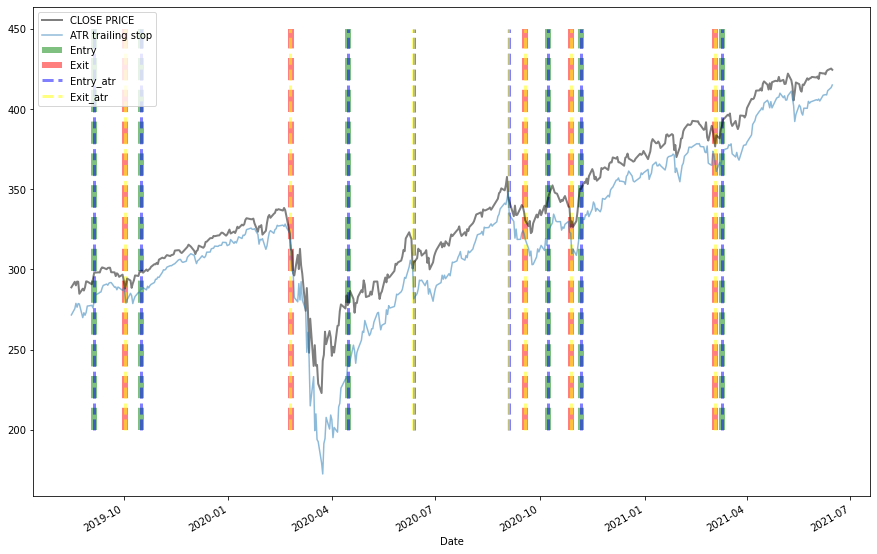

In [57]:
plt.rcParams['figure.figsize'] = [15, 10]
# plt.rc('font', size = 14)
fig, ax = plt.subplots()

stock['Close'].plot(label = 'CLOSE PRICE', color = 'black',\
                    linewidth = 2, alpha = 0.5, ax = ax)
stock['ATR_stop'].plot(label = 'ATR trailing stop', alpha = 0.5, ax = ax)
# stock['EMA_S'].plot(label = 'EMA_S', alpha = 0.5, ax = ax)
# stock['EMA_L'].plot(label = 'EMA_L', alpha = 0.5, ax = ax)
ax.vlines(Entry.reset_index().Date, ymin = 200, ymax = 450,\
          color = 'green', linestyle = '--', label = 'Entry', alpha = 0.5, linewidth = 6)
ax.vlines(Exit.reset_index().Date, ymin = 200, ymax = 450,\
          color = 'red', linestyle = '--', label = 'Exit', alpha = 0.5, linewidth = 6)
ax.vlines(Entry_atr.reset_index().Date, ymin = 200, ymax = 450,\
          color = 'blue', linestyle = '--', label = 'Entry_atr', alpha = 0.5, linewidth = 3)
ax.vlines(Exit_atr.reset_index().Date, ymin = 200, ymax = 450,\
          color = 'yellow', linestyle = '--', label = 'Exit_atr', alpha = 0.5, linewidth = 3)

plt.legend(loc = 'upper left')
plt.show()

In [47]:
stock.loc[:,'atr_rtn'] = stock.pos.shift(1) * stock.rtn # with strategy
stock['atr_crtn'] = stock['atr_rtn'].cumsum().apply(np.exp) # with strategy

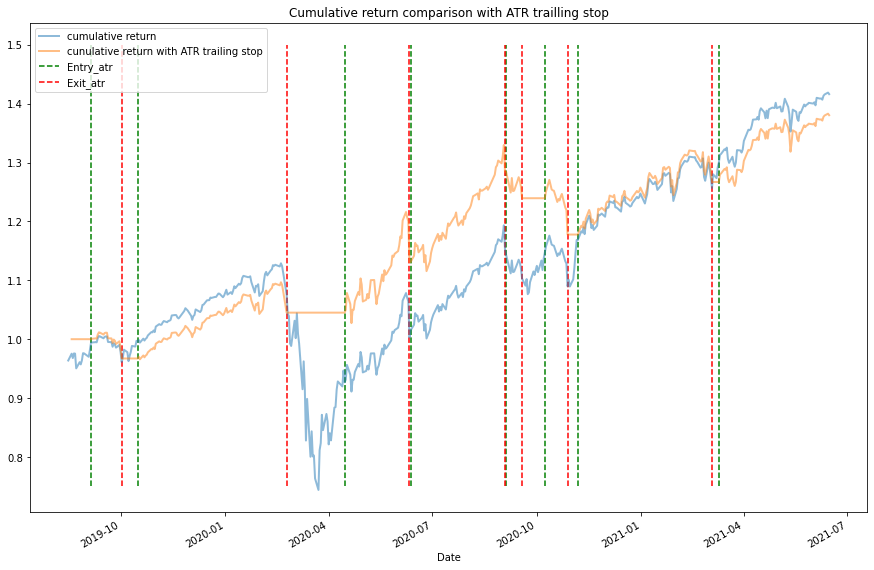

In [53]:
fig, ax = plt.subplots()

stock['crtn'].plot(label = 'cumulative return', linewidth = 2, alpha = 0.5, ax = ax)
stock['atr_crtn'].plot(label = 'cunulative return with ATR trailing stop', linewidth = 2, alpha = 0.5, ax = ax)
ax.vlines(Entry_atr.reset_index().Date, ymin = 0.75, ymax = 1.5, color = 'green', linestyle = '--', label = 'Entry_atr')
ax.vlines(Exit_atr.reset_index().Date, ymin = 0.75, ymax = 1.5, color = 'red', linestyle = '--', label = 'Exit_atr')

plt.legend(loc = 'upper left')
plt.title('Cumulative return comparison with ATR trailling stop')
plt.show()